In [1]:
from hmc.state.grid_state import GridState
from hmc.model.xy_model import XYModel
from hmc.monte_carlo.hmc import IsingHMC, XYHMC
from hmc.integrator.leap_frog import LeapFrogIntegrator
from hmc.integrator.leap_frog_autograd import LeapFrogIntegratorAutoGrad
from hmc.monte_carlo.metropolis import IsingContinuousMetropolis

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import torch


In [2]:
dim = 2 # dimension of Ising model
L = 16 # length of grid
grid = GridState(dim=2,length=6)

J = 1.0 # spin-spin interaction coupling
h = 0.0  # External field

# Check the analytical grad coincide with the Auto grad

In [3]:
step_size = 0.1
trajectory_length = 1
n_steps = int(trajectory_length/step_size)

leap_frog = LeapFrogIntegratorAutoGrad(step_size, n_steps)
model = XYModel(grid_state=grid,beta=0.5, J=J, h=h) # define ising state

# calculate theoretical gradient
psi = np.random.randn(model.grid.n_sites)
mom = np.random.randn(model.grid.n_sites)
grad_U_theory = model.get_gradU(psi)
grad_K_theory = mom

# calculate gradient with torch autograd
psi = torch.tensor(psi,requires_grad=True)
mom = torch.tensor(mom,requires_grad=True)
pos_grad, mom_grad = leap_frog.get_grad(hamiltonian_func=model.get_hamiltonian_torch, pos=psi, mom=mom)
grad_U_autograd =pos_grad.numpy()
grad_K_autograd = mom_grad.numpy()


grad_U_diff = np.max(np.abs(grad_U_theory - grad_U_autograd))
grad_K_diff = np.max(np.abs(grad_K_theory - grad_K_autograd))

print(f"Difference of gradient of potential energy: {grad_U_diff}")
print(f"Difference of gradient of kinetic energy: {grad_K_diff}")

Difference of gradient of potential energy: 2.220446049250313e-16
Difference of gradient of kinetic energy: 0.0


In [4]:
model = XYModel(grid_state=grid,beta=0.5, J=J, h=h) # define ising state
print(model.get_magnetization(model.get_state()))

0.0963187907852179


# Test the curve

In [5]:

beta_list = np.linspace(0.6,1.4,8*2+1)
metropolis_m_list = []
n_rounds = 10


for beta in beta_list:
    rounds_list = []
    for _ in range(n_rounds):
        
        model = XYModel(grid_state=grid, beta=beta, J=J, h=h) # define ising state
        mc = IsingContinuousMetropolis(ising_model=model) # define Monte Carlo algorithm
        measurements = {"m": model.get_magnetization} # define physics observable to be measured
        # sample and generate result
        measured_result = mc.sample(measurements=measurements,n_samples=400,n_iters_per_sample=100,n_thermalization_iters=40000)
        m_abs = np.absolute(measured_result["m"]).mean()
        rounds_list.append(m_abs)
        #print(f"beta: {beta},  magnetization: {m_abs} ")
    metropolis_m_list.append(rounds_list)    
metropolis_m_list = np.array(metropolis_m_list)

KeyboardInterrupt: 

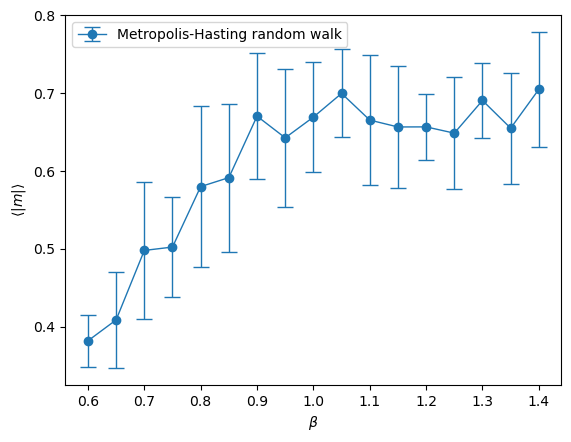

In [ ]:
m_mean_metro = metropolis_m_list.mean(axis=-1)
m_std_metro = metropolis_m_list.std(axis=-1)

fig, ax = plt.subplots()
ax.errorbar(beta_list, m_mean_metro, m_std_metro, fmt='o-', linewidth=1, capsize=6, label ="Metropolis-Hasting random walk")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.legend()
fig.show()

In [3]:
step_size = 0.1 # step size of integrator
trajectory_length = 1
n_steps = int(trajectory_length/step_size) # number of steps in a trajectory
leap_frog = LeapFrogIntegrator(step_size, n_steps) # define integrator

In [4]:

beta_list = np.linspace(0.5,1.5,10*2+1) # define beta valueus to measure
n_rounds = 10

hmc_m_list = []
for beta in beta_list:
    rounds_list = []
    for _ in range(n_rounds):
        model = XYModel(grid_state=grid,beta=beta, J=J, h=h) # define ising state
        mc = XYHMC(ising_model=model,integrator=leap_frog) # define Monte Carlo algorithm
        measurements = {"m": model.get_magnetization} # define physics observable to be measured
        # sample and generate result
        measured_result = mc.sample(measurements=measurements,n_samples=100,n_iters_per_sample=10,n_thermalization_iters=1000)
        m_abs = np.absolute(measured_result["m"]).mean()
        rounds_list.append(m_abs)
    hmc_m_list.append(rounds_list)      
hmc_m_list = np.array(hmc_m_list)

KeyboardInterrupt: 

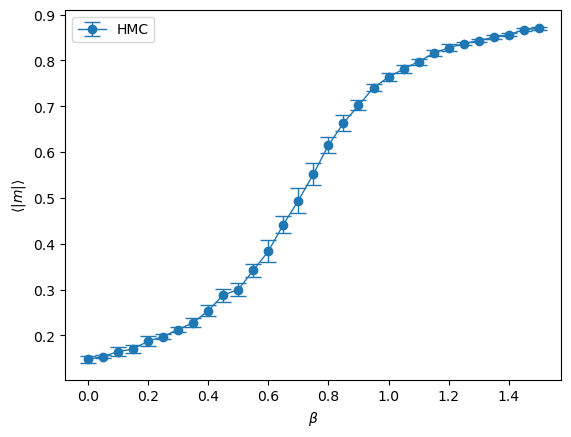

In [9]:
m_mean_hmc = hmc_m_list.mean(axis=-1)
m_std_hmc = hmc_m_list.std(axis=-1)

fig, ax = plt.subplots()

ax.errorbar(beta_list, m_mean_hmc, m_std_hmc, fmt='o-', linewidth=1, capsize=6, label="HMC")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.legend()
fig.show()

# Data generation

In [53]:
def measure(beta_list):
    energy_list = []
    magnetization_list=[]
    m2_list =[]
    heat_capacity_list=[]

    for beta in beta_list:
        model = XYModel(grid_state=grid,beta=beta, J=J, h=h) # define ising state
        mc = XYHMC(ising_model=model,integrator=leap_frog) # define Monte Carlo algorithm
        measurements = {"magnetization": model.get_magnetization, "energy":model.get_energy} # define physics observable to be measured
        history = mc.sample(measurements=measurements,n_samples=4000,n_iters_per_sample=100,n_thermalization_iters=4000)
        
        energy_list.append(np.mean(history["energy"])/model.grid.n_sites)
        magnetization_list.append(np.mean(history["magnetization"]))
        m2_list.append(np.mean(np.square(history["magnetization"])))
        heat_capacity_list.append(np.var(history["energy"])*beta*beta/model.grid.n_sites)
   
    measurement = {
        "beta": beta_list, 
        "magnetization": magnetization_list,
        "m2": m2_list,
        "energy": energy_list,
        "heat_capacity": heat_capacity_list,
    }
    return measurement


In [65]:
beta_list1 = np.linspace(0.5,1.5,10+1) # define beta valueus to measure
beta_list2 = np.linspace(0.7,1.0, 15+1)
beta_list = np.concatenate((beta_list1,beta_list2))
beta_list = np.unique(np.sort(beta_list))


In [67]:
measurement  = measure(beta_list)

In [69]:
df = pd.DataFrame(data=measurement)
filename = "./data/xy_model.csv"
df.to_csv(filename)

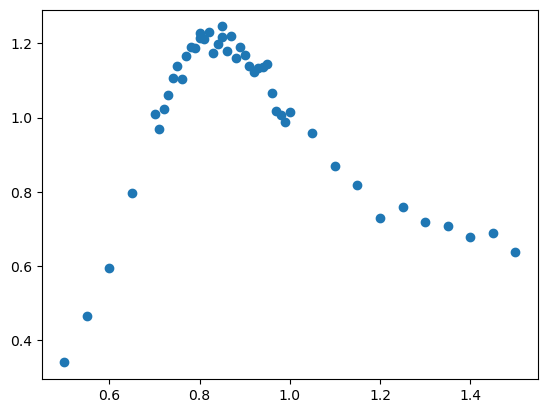

In [72]:
fig, ax = plt.subplots()

beta = df["beta"].to_numpy()
cv = df["heat_capacity"].to_numpy()
temp = 1/beta
ax.scatter(beta, cv, marker="o")

In [73]:
print(beta)

[0.5  0.55 0.6  0.65 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.8  0.81 0.82 0.83 0.84 0.85 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.05 1.1  1.15 1.2  1.25
 1.3  1.35 1.4  1.45 1.5 ]
